# Exploratory analysis for health risk assessment, and propose new assessment method if possible

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style("whitegrid")
np.random.seed(42)

Inspect the relationship between risk estimate and feature values in SBP, DBP, TC

Text(0.5,1,'TC($mg/dl$)')

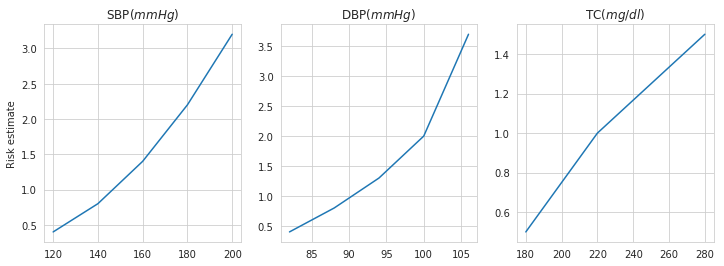

In [2]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(range(120, 201, 20), [0.4, 0.8, 1.4, 2.2, 3.2])
plt.title("SBP($mmHg$)")
plt.ylabel("Risk estimate")

plt.subplot(1, 3, 2)
plt.plot(range(82, 107, 6), [0.4, 0.8, 1.3, 2.0, 3.7])
plt.title("DBP($mmHg$)")

plt.subplot(1, 3, 3)
plt.plot([180, 220, 280], [0.5, 1.0, 1.5])
plt.title("TC($mg/dl$)")

In [3]:
class Feature(object):
    def __init__(self, data, kind="categorical"):
        assert kind in ['categorical', 'numerical']
        self.kind = kind
        self.data = data
        self.num_features = len(data)
        self.std = (max(data.values()) - min(data.values())) / 6
#         self.mean = (max(data.values()) + min(data.values())) / 2
        self.mean = 1.0
        if kind == 'numerical':
            self.items = np.array(list(data.items()))
        
    def get_value(self, value):
        if value is None: return value
        if self.kind == 'categorical':
            return self.data.get(value, None)
        if self.kind == 'numerical':
            if np.isnan(value): return value
            mi = self.items[:, 0].min()
            ma = self.items[:, 0].max()
            if value <= mi: return mi
            if value >= ma: return ma
            pr = k[k - value < 0].max()
            po = k[k - value > 0].min()
            return (value - pr) * (po - pr) / (k[po] - k[pr]) + k[pr]

    def round_rf(self, value):
        if self.kind == 'categorical':
            # TODO: use matrix multiplication (currently can only be applied element-wise).
            return self.items[(self.items[:, 1] - value).argmin(), 1]
        return np.where(value > 0, value, 0)  # clipping


def gen_sample(feat, num_samples=10):
    sample = pd.DataFrame()
    for k, f in feat.items():
        sample[k] = f.round_rf(np.random.normal(f.mean, f.std, num_samples))
    return sample


def risk_orig(row):
    return np.sum(row[row > 1.0].values) + np.prod(row[row < 1.0].values)

In [4]:
features = {
    "SBP": Feature({a: b for a, b in zip(range(120, 201, 20), [0.4, 0.8, 1.4, 2.2, 3.2])}, kind="numerical"),
    "DBP": Feature({a: b for a, b in zip(range(82, 107, 6), [0.4, 0.8, 1.3, 2.0, 3.7])}, kind="numerical"),
    "TC": Feature({a: b for a, b in zip([180, 220, 280], [0.5, 1.0, 1.5])}, kind="numerical"),
}

## Randomly generated samples (currently not used)

Given statistics of feature $F$, draw features from a gaussian distribution $N(1.0, \frac{max_F - min_F}{6})$,
where $max_F$ denote the maximum of $F$ and $min_F$ denote the minimum.

In [5]:
sample = gen_sample(features, 5000)

sample.head()

,SBP,DBP,TC
0,1.231800,0.766932,0.886918
1,0.935477,0.750622,0.949083
2,1.302255,0.012396,0.900436
3,1.710747,0.818450,1.018403
4,0.890728,1.403056,1.199530


In [6]:
sample_orig = sample[list(features.keys())]
sample['Risk_Orig'] = sample_orig.apply(risk_orig, axis=1)
sample.head()

,SBP,DBP,TC,Risk_Orig
0,1.231800,0.766932,0.886918,1.912006
1,0.935477,0.750622,0.949083,0.666436
2,1.302255,0.012396,0.900436,1.313417
3,1.710747,0.818450,1.018403,3.547601
4,0.890728,1.403056,1.199530,3.493314


## What a good model should meet
1. Be robust to null values
1. Given a standardized feature importance (risk estimate), the differences along both axes should be similar

## Compare the original method with our proposed method (with 2 features)

### The original method
The original method use

$$ R = \sum_{k \in X_+} k + \prod_{l \in X_-} l $$

Where $X_+$ is the set of all original data that are greater than 1.0,
and $X_-$ is the set where original data are less than or equal 1.0,

Text(0.5,1,'Risk Estimate Distribution with the original method')

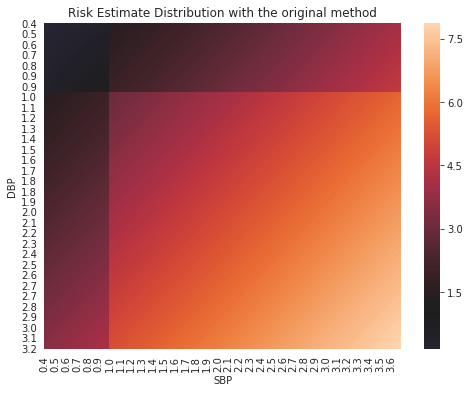

In [7]:
xv, yv = np.meshgrid(np.arange(0.4, 3.2, 0.01), np.arange(0.4, 3.7, 0.01))
mesh_data = np.concatenate([xv.reshape((-1, 1)), yv.reshape((-1, 1))], axis=1)

# The original method
mesh_data = np.sum(np.where(mesh_data > 1.0, mesh_data, 0), 1) + np.prod(np.where(mesh_data < 1.0, mesh_data, 1.0), 1)

mesh_data = pd.DataFrame(mesh_data.reshape((xv.shape[0], xv.shape[1])).T,
                         index=np.round(np.arange(0.4, 3.2, 0.01), 1),
                         columns=np.round(np.arange(0.4, 3.7, 0.01), 1))

plt.figure(figsize=(8, 6))
sns.heatmap(mesh_data, center=1.0)
plt.xlabel("SBP")
plt.ylabel("DBP")
plt.title("Risk Estimate Distribution with the original method")

A sudden value change at $F = 1.0$ is observed in the figure above.

## Our proposed method

*Yet to be implemented*

Should a Linear Regression model with null values filled with 1.0 work?

## Questions

### How to assess the model?

What we are doing are hopefully *Regression*, the error of estimated age can be calculated for both approaches.

**(That means we have to use existing dataset, as it will take a relatively long time to collect a new one.)**

### Why simple averaging cannot be used?
1. [x] Be robust to null values
1. [x] Given a standardized feature importance (risk estimate), the differences along both axes should be similar

Text(0.5,1,'Risk Estimate Distribution with the original method')

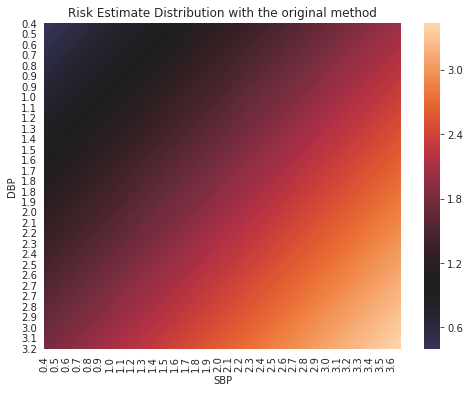

In [8]:
xv, yv = np.meshgrid(np.arange(0.4, 3.2, 0.01), np.arange(0.4, 3.7, 0.01))
mesh_data = np.concatenate([xv.reshape((-1, 1)), yv.reshape((-1, 1))], axis=1)

# The average
mesh_data = np.sum(mesh_data, 1) / mesh_data.shape[1]

mesh_data = pd.DataFrame(mesh_data.reshape((xv.shape[0], xv.shape[1])).T,
                         index=np.round(np.arange(0.4, 3.2, 0.01), 1),
                         columns=np.round(np.arange(0.4, 3.7, 0.01), 1))

plt.figure(figsize=(8, 6))
sns.heatmap(mesh_data, center=1.0)
plt.xlabel("SBP")
plt.ylabel("DBP")
plt.title("Risk Estimate Distribution with the original method")

## Resources
1. http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.902.5920&rep=rep1&type=pdf
1. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1065455/
1. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1065456/